In [0]:
# REPLACE by your individual
my_individual = 'HG01149'

## Installing requirements

In [0]:
# Connect to github and load the necessary data and tools
%%capture
!export LD_LIBARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!apt install libgsl-dev
!ln -s /usr/lib/x86_64-linux-gnu/libgsl.so /usr/lib/x86_64-linux-gnu/libgsl.so.0
!git clone https://github.com/priyamoorjani/CCB293.git
!chmod +x CCB293/bin/smartpca
!chmod +x CCB293/bin/admixture
!cd CCB293/data/1000G_archaic && unzip 1000G_archaic.geno.zip
!cd CCB293/data/1000G_archaic && git clone https://github.com/LauritsSkov/Introgression-detection.git

In [0]:
# SKIP
#%%capture
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/accessible_genome_masks/StrictMask/20140520.chr17.strict_mask.fasta.gz -O 20140520.chr17.strict_mask.fasta.gz
#!wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/chromFaMasked.tar.gz
#!tar xzvf chromFaMasked.tar.gz
#!wget http://web.corral.tacc.utexas.edu/WGSAdownload/resources/human_ancestor_GRCh37_e71/homo_sapiens_ancestor_17.fa.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
#!apt install autoconf autogen
#!git clone https://github.com/vcftools/vcftools.git
#!cd vcftools && ./autogen.sh && ./configure && make && make install
#!git clone https://github.com/samtools/htslib.git
#!cd htslib && autoheader && autoconf && ./configure && make && make install
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz.tbi
#!gunzip homo_sapiens_ancestor_17.fa.gz

In [0]:
# load the libraries
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import colorsys
import seaborn as sns
from IPython.display import Image
import os

In [0]:
# define plotting functions

def plot_pcs(pcs, I, J, labels, indivs=None):
    PCI = 'PC{}'.format(I)
    PCJ = 'PC{}'.format(J)
    plt.figure(figsize=(10,10))
    #colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,len(np.unique(labels))+1)[:-1]]
    #colors = ['#acc2d9', '#653700', '#b2996e', '#a8ff04', 'xkcd:orange', '#894585',
    #          '#70b23f', '#d4ffff', '#65ab7c', '#952e8f', '#fcfc81', '#a5a391',
    #          '#388004', '#4c9085', '#5e9b8a', '#efb435', '#d99b82', '#0a5f38',
    #          '#0c06f7', '#61de2a', '#3778bf', '#2242c7', '#533cc6', '#9bb53c',
    #          '#05ffa6', '#1f6357', '#017374', '#0cb577']

    colors = [
        "#7e1e9c", "#15b01a", "#0343df", "#ff81c0","#653700","#e50000","#029386",
        "#f97306", "#96f97b", "#c20078", "#ffff14", "#95d0fc", "#929591",
        "#9a0eea",
        "#033500",
        "#00035b",
        "#06c2ac",
        "#d1b26f",
        "#00ffff",
        "#650021",
        "#ffb07c",
        "#ff796c",
        "#36013f",
        "#c65102",
        "#000000",
        "#c1f80a",
        "#4b5d16",
        "#0652ff"
    ]
    

    print(len(np.unique(labels)))
    for i, p in enumerate(np.unique(labels)):
        pcs_p = pcs[labels==p]
        plt.scatter(pcs_p[PCI], pcs_p[PCJ], label=p, color=colors[i])
    plt.legend(loc=(1.04,0))
    if indivs is not None:
        for individual in indivs:
            pcs_i = pcs[pcs.Sample==individual]
            plt.annotate(individual, [pcs_i[PCI], pcs_i[PCJ]])
            plt.plot(pcs_i[PCI], pcs_i[PCJ], 'o', color='black')
    plt.xlabel(PCI)
    plt.ylabel(PCJ);


def plot_admixture(admixture, population_indices, population_labels):
    plot = plt

    N,K = admixture.shape
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    text_color = 'k'
    bg_color = 'w'
    fontsize = 24

    figure = plot.figure(figsize=(5,3))

    xmin = 0.13
    ymin = 0.2
    height = 1.2#0.6
    width = 1.5#0.74
    indiv_width = width/N
    subplot = figure.add_axes([xmin,ymin,width,height])
    [spine.set_linewidth(0.001) for spine in subplot.spines.values()]

    for k in np.arange(K):
        if k:
            bottoms = admixture[:,:k].sum(1)
        else:
            bottoms = np.zeros((N,),dtype=float)

        lefts = np.arange(N)*indiv_width
        subplot.bar(lefts, admixture[:,k], width=indiv_width, bottom=bottoms, facecolor=colors[k], edgecolor=colors[k], linewidth=0.4)

        subplot.axis([0, N*indiv_width, 0, 1])
        subplot.tick_params(axis='both', top=False, right=False, left=False, bottom=False)
        xtick_labels = tuple(map(str,['']*N))
        subplot.set_xticklabels(xtick_labels)
        ytick_labels = tuple(map(str,['']*K))
        subplot.set_yticklabels(ytick_labels)

    for p,popname in enumerate(population_labels):
        indices = np.where(population_indices==p)[0]
        if indices.size>0:
            vline_pos = (indices.max()+1)*indiv_width 
            subplot.axvline(vline_pos, linestyle='-', linewidth=0.2, c='#888888')
            label_position = (xmin+(2*indices.min()+indices.size)*0.5*indiv_width, ymin-0.01)
            figure.text(label_position[0], label_position[1], popname, fontsize=12, color='k', \
                horizontalalignment='right', verticalalignment='top', rotation=70)

    return figure

def plot_admix_individual(admix, individual):
    K = admix.shape[1]
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    plt.pie(admix[individuals.individual==individual][0], colors=colors)
    plt.title(individual);

def plot_window_assignment(window_assignment):
    plt.scatter(np.arange(len(window_assignment)), window_assignment, s=8)
    plt.xlabel('window')
    plt.yticks([0,1], ['Human', 'Archaic'])

## Exploring the data

In [6]:
# set current directory
%cd /content/CCB293/data/1000G_archaic/

/content/CCB293/data/1000G_archaic


In [0]:
# Read the individual file. For more information about file formats, refer to: https://reich.hms.harvard.edu/software/InputFileFormats 
individuals = pd.read_csv('1000G_archaic.ind', delim_whitespace=True, header=None, names=['individual', 'sex', 'population'])

In [8]:
# 1000 Genomes Populations and 3 letter codes. For reference, see population_info.csv
%%writefile population_info.csv
population,description,super_population
CHB,Han Chinese in Beijing China,EAS
JPT,Japanese in Tokyo - Japan,EAS
CHS,Southern Han Chinese,EAS
CDX,Chinese Dai in Xishuangbanna - China,EAS
KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,EUR
TSI,Toscani in Italia,EUR
FIN,Finnish in Finland,EUR
GBR,British in England and Scotland,EUR
IBS,Iberian Population in Spain,EUR
YRI,Yoruba in Ibadan - Nigeria,AFR
LWK,Luhya in Webuye - Kenya,AFR
GWD,Gambian in Western Divisions in the Gambia,AFR
MSL,Mende in Sierra Leone,AFR
ESN,Esan in Nigeria,AFR
ASW,Americans of African Ancestry in SW USA,AFR
ACB,African Caribbeans in Barbados,AFR
MXL,Mexican Ancestry from Los Angeles USA,AMR
PUR,Puerto Ricans from Puerto Rico,AMR
CLM,Colombians from Medellin - Colombia,AMR
PEL,Peruvians from Lima - Peru,AMR
GIH,Gujarati Indian from Houston - Texas,SAS
PJL,Punjabi from Lahore - Pakistan,SAS
BEB,Bengali from Bangladesh,SAS
STU,Sri Lankan Tamil from the UK,SAS
ITU,Indian Telugu from the UK,SAS

Writing population_info.csv


In [9]:
# Display population labels
population_info = pd.read_csv('population_info.csv')
population_info

,population,description,super_population
0,CHB,Han Chinese in Beijing China,EAS
1,JPT,Japanese in Tokyo - Japan,EAS
2,CHS,Southern Han Chinese,EAS
3,CDX,Chinese Dai in Xishuangbanna - China,EAS
4,KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
5,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR
6,TSI,Toscani in Italia,EUR
7,FIN,Finnish in Finland,EUR
8,GBR,British in England and Scotland,EUR
9,IBS,Iberian Population in Spain,EUR


In [0]:
# Update file with labels for archaic groups
individuals = individuals.merge(population_info, on='population', how='left').fillna('Archaic')

In [0]:
# 1000 Genomes super_population - AFR = Africa, EUR = Europe, SAS = South Asia, EAS = East Asia, AMR = Americas, Archaic = Neanderthal/ Denisova
individuals.population = individuals.population.astype('category')
individuals.super_population = pd.Categorical(
    individuals.super_population, 
    categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR', 'Archaic'],
    ordered=True)

In [0]:
# sort individuals by population
individuals = individuals.sort_values(['super_population', 'population'])

In [13]:
# Display Ind file. Format: https://reich.hms.harvard.edu/software/InputFileFormats
individuals.tail()

,individual,sex,population,description,super_population
468,HG01412,m,PUR,Puerto Ricans from Puerto Rico,AMR
469,HG01413,m,PUR,Puerto Ricans from Puerto Rico,AMR
470,HG01414,f,PUR,Puerto Ricans from Puerto Rico,AMR
2505,Denisova,U,Denisova,Archaic,Archaic
2504,Altai,U,Neanderthal,Archaic,Archaic


In [0]:
# order individual indexes
order = individuals.index

In [0]:
# Set my_individual's continental group
my_individual_index = np.where(individuals.individual==my_individual)[0][0]
my_continental_group = individuals.iloc[my_individual_index].super_population

In [16]:
# Display SNP file. Format: https://reich.hms.harvard.edu/software/InputFileFormats
snps = pd.read_csv('1000G_archaic.snp', delim_whitespace=True, header=None, names=['id', 'chr', 'recomb. rate', 'position', 'allele 1', 'allele 2'])
print(snps.shape)
snps.head()

(19998, 6)


,id,chr,recomb. rate,position,allele 1,allele 2
0,rs4970443,1,0.000000,1316887,G,A
1,rs61776606,1,0.000001,2086497,G,A
2,rs2036084,1,0.000002,2269881,A,G
3,rs10910061,1,0.000002,2303512,G,A
4,rs3791182,1,0.000007,2448188,A,G


In [17]:
# Display genotype file. Format: https://reich.hms.harvard.edu/software/InputFileFormats
genotypes = pd.read_fwf('1000G_archaic.geno', widths=np.ones(2506, dtype=int).tolist(), header=None)
print(genotypes.shape)
genotypes.head()

(19998, 2506)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505
0,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2,1,1,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2,1,1,2,2,2,0,1,2,1,2,2,1,2,1,1,1,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,0
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,1,1,1,2,2,2,2,1,2,2,2,1,1,2,2,2,2,2,2,2,1,1,0,1,1,2,2,1,2,2,1,2,1,1,2,1,1,2,2,2,...,2,0,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,0,2,2,1,1,0,1,1,1,0,1,1,1,2,1,0,2,1,0,0,2,2,2


# Principal Component Analysis (PCA)

Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006): e190.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190

Software documentation: https://github.com/DReichLab/EIG/tree/master/POPGEN

Usage: `!../../bin/smartpca -p 1000G_archaic.smartpca.par`

In [18]:
# Parameter file (1000G_archaic.smartpca.par)
%%writefile 1000G_archaic.smartpca.par
genotypename: 1000G_archaic.geno     # file with genotype information
snpname:      1000G_archaic.snp      # file with snp information
indivname:    1000G_archaic.ind      # file with individual information   
#poplistname:  1000G_archaic.pop.list # list of pops to include in the run.
outliermode: 2
evecoutname:  1000G_archaic.evec     # output file of eigenvectors.
evaloutname:  1000G_archaic.eval     # output file of all eigenvalues
snpweightoutname: 1000G_archaic.Weightout.txt
phylipname:   1000G_archaic.phyl     # file with Fst values across populations 
numoutevec:   20               # number of PCs to output 
numthreads:   1                # if running interactively, use 1 only

Writing 1000G_archaic.smartpca.par


In [0]:
# Run smartpca 
%%capture
!../../bin/smartpca -p 1000G_archaic.smartpca.par

In [20]:
# Display results - evec file. File contains loadings for each individual on the 20 PCs. https://github.com/DReichLab/EIG/tree/master/POPGEN
n_pcs = 20
pcs = pd.read_csv('1000G_archaic.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left').fillna('Archaic')
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,population,description,super_population
0,HG00096,0.0115,0.0260,0.0135,0.0176,-0.0005,-0.0031,0.0009,0.0015,-0.0114,-0.0040,-0.0062,-0.0085,-0.0079,-0.0028,0.0112,0.0011,-0.0026,-0.0098,0.0045,0.0063,GBR,British in England and Scotland,EUR
1,HG00097,0.0105,0.0263,0.0103,0.0178,0.0001,0.0015,-0.0015,0.0053,-0.0132,-0.0012,-0.0055,0.0020,-0.0007,-0.0066,-0.0008,0.0041,-0.0102,-0.0017,0.0106,0.0033,GBR,British in England and Scotland,EUR
2,HG00099,0.0114,0.0268,0.0135,0.0165,0.0037,-0.0020,0.0039,0.0022,-0.0072,-0.0023,0.0052,-0.0008,0.0052,-0.0003,0.0139,-0.0053,-0.0132,0.0038,-0.0130,-0.0053,GBR,British in England and Scotland,EUR
3,HG00100,0.0109,0.0255,0.0112,0.0187,0.0004,-0.0014,0.0048,0.0029,-0.0082,-0.0020,-0.0030,-0.0023,-0.0117,-0.0004,0.0185,0.0046,-0.0089,-0.0080,-0.0069,-0.0016,GBR,British in England and Scotland,EUR
4,HG00101,0.0116,0.0260,0.0141,0.0216,-0.0014,0.0023,-0.0011,0.0032,-0.0100,-0.0055,0.0022,-0.0061,0.0015,-0.0055,-0.0046,0.0107,-0.0062,-0.0118,0.0051,-0.0106,GBR,British in England and Scotland,EUR


6


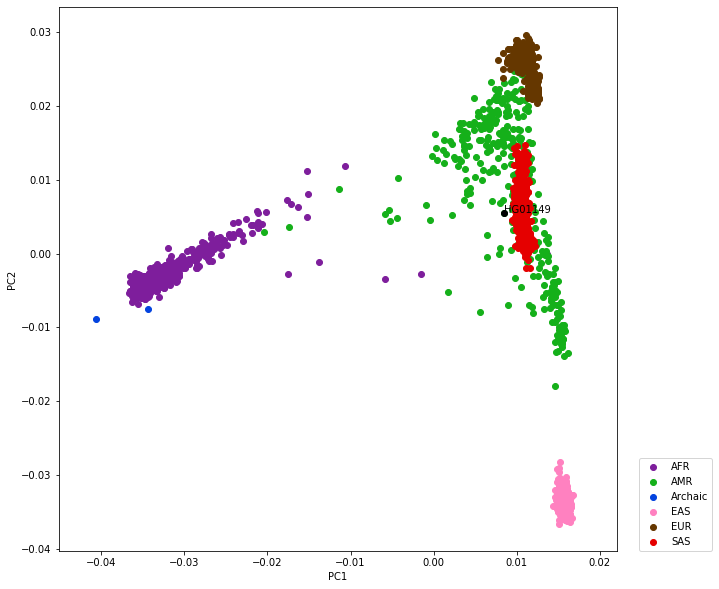

In [21]:
# Plot the top two PCs. Population labels = super_population
plot_pcs(pcs, 1, 2, pcs.super_population, [my_individual])

28


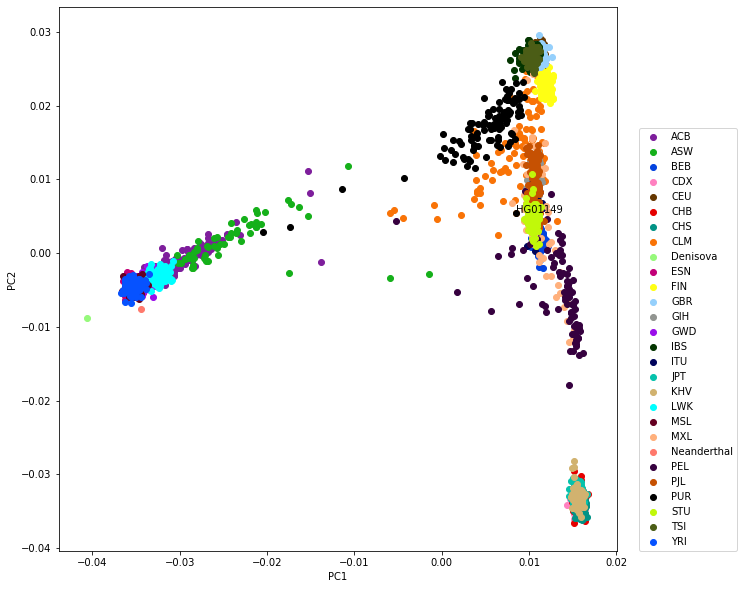

In [22]:
# Plot the top two PCs. Population labels = population
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

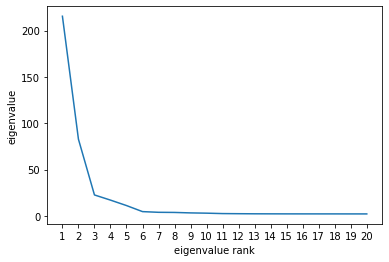

In [23]:
# Display eigenvalues. https://github.com/DReichLab/EIG/tree/master/POPGEN
eigenvalues = np.loadtxt('1000G_archaic.eval')
plt.plot(np.arange(1, 21), eigenvalues[:20])
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue');

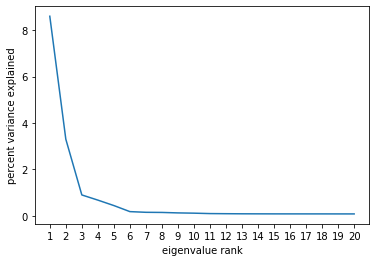

In [24]:
# Display %variance explained
eigenvalues = np.loadtxt('1000G_archaic.eval')
plt.plot(np.arange(1, 21), 100 * eigenvalues[:20] / eigenvalues.sum())
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('percent variance explained');

In [25]:
# FST between populations
!cat 1000G_archaic.phyl

    28
       GBR 0.000 0.007 0.113 0.011 0.113 0.016 0.003 0.088 0.030 0.109 0.120 0.147 0.152 0.041 0.151 0.043 0.042 0.000 0.151 0.111 0.112 0.140 0.093 0.037 0.004 0.036 0.602 0.609
       FIN 0.007 0.000 0.105 0.016 0.105 0.019 0.011 0.084 0.031 0.101 0.122 0.149 0.154 0.040 0.153 0.043 0.042 0.006 0.153 0.102 0.103 0.142 0.095 0.037 0.012 0.037 0.604 0.610
       CHS 0.113 0.105 0.000 0.089 0.005 0.080 0.113 0.084 0.075 0.003 0.153 0.175 0.179 0.059 0.178 0.072 0.073 0.113 0.178 0.001 0.009 0.168 0.131 0.070 0.112 0.077 0.626 0.631
       PUR 0.011 0.016 0.089 0.000 0.089 0.006 0.009 0.060 0.023 0.086 0.082 0.105 0.110 0.030 0.109 0.033 0.032 0.011 0.109 0.087 0.087 0.099 0.059 0.020 0.010 0.028 0.570 0.576
       CDX 0.113 0.105 0.005 0.089 0.000 0.081 0.113 0.088 0.074 0.002 0.152 0.173 0.178 0.059 0.177 0.071 0.073 0.112 0.177 0.009 0.017 0.167 0.130 0.073 0.112 0.077 0.625 0.630
       CLM 0.016 0.019 0.080 0.006 0.081 0.000 0.015 0.041 0.024 0.077 0.095 0.119 0.124 0.029 0.1

## Exercise: explore your continental group

In [0]:
# Write population list. 
np.savetxt('pop.list', individuals[individuals.super_population==my_continental_group].population.unique().astype(str), fmt='%s')

In [27]:
%%writefile 1000G_archaic.continent.smartpca.par
genotypename: 1000G_archaic.geno     # file with genotype information
snpname:      1000G_archaic.snp      # file with snp information
indivname:    1000G_archaic.ind      # file with individual information   
poplistname:  pop.list # list of pops to include in the run.
evecoutname:  1000G_archaic.continent.evec     # output file of eigenvectors.
evaloutname:  1000G_archaic.continent.eval     # output file of all eigenvalues
snpweightoutname: 1000G_archaic.continent.Weightout.txt
phylipname:   1000G_archaic.continent.phyl     # file with Fst values across populations 
numoutevec:   10               # number of PCs to output 
numthreads:   1                # if running interactively, use 1 only
outliermode: 2
#outliermode should be 0, 1 or 2 
#mode = 2  NO outlier removal 
#mode = 1  when calculating mean and standard deviation of a PC to decide whether to remove a sample the 
# sample itself is not used.   This may be important for datasets with very small sample sizes (say less than 30).  
#mode = 0  (default) use all samples to compute PC mean and variance. 

Writing 1000G_archaic.continent.smartpca.par


In [0]:
# Run smartpca
%%capture
!../../bin/smartpca -p 1000G_archaic.continent.smartpca.par

In [29]:
# Display output
n_pcs = 10
pcs = pd.read_csv('1000G_archaic.continent.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left').fillna('Archaic')
pcs = pcs[pcs.super_population==my_continental_group]
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,population,description,super_population
227,HG00551,-0.0492,-0.0260,-0.0063,-0.0024,0.0068,-0.0162,-0.0015,0.0427,0.0180,-0.0179,PUR,Puerto Ricans from Puerto Rico,AMR
228,HG00553,-0.0416,0.0411,-0.0062,-0.0257,0.0223,-0.0026,0.0342,0.0354,0.0769,-0.0034,PUR,Puerto Ricans from Puerto Rico,AMR
229,HG00554,-0.0490,-0.0211,0.0055,-0.0029,0.0260,0.0234,0.0073,0.0302,0.0051,0.0025,PUR,Puerto Ricans from Puerto Rico,AMR
265,HG00637,-0.0579,0.0025,0.0086,-0.0127,0.0243,0.0368,0.0245,0.0059,0.0417,0.0118,PUR,Puerto Ricans from Puerto Rico,AMR
266,HG00638,-0.0539,0.0175,0.0001,-0.0223,0.0593,0.0256,0.0787,-0.0052,0.0525,0.0636,PUR,Puerto Ricans from Puerto Rico,AMR


4


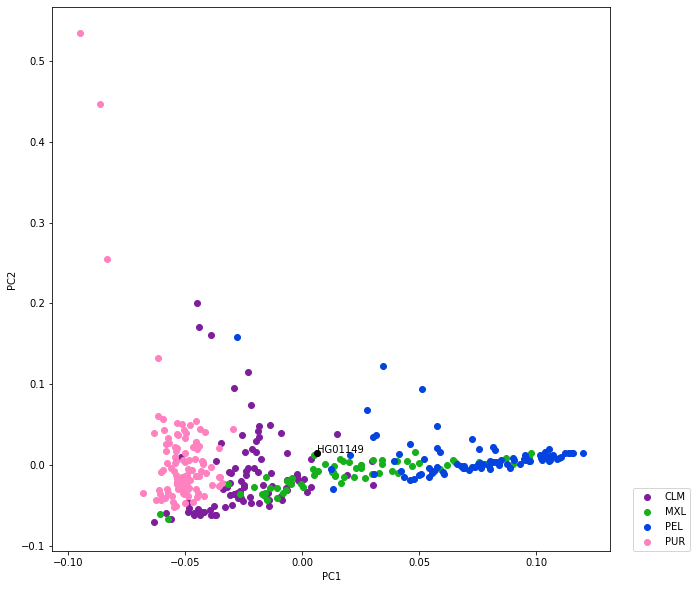

In [30]:
# plot PCA output
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

In [31]:
# Display information about current individual from 1000G
individuals.iloc[my_individual_index]

individual                                      HG01149
sex                                                   f
population                                          CLM
description         Colombians from Medellin - Colombia
super_population                                    AMR
Name: 379, dtype: object

In [32]:
# FST between populations
!cat 1000G_archaic.continent.phyl

     4
       CLM 0.000 0.010 0.041 0.006
       MXL 0.010 0.000 0.018 0.020
       PEL 0.041 0.018 0.000 0.060
       PUR 0.006 0.020 0.060 0.000


# Admixture analysis

Alexander, David H., John Novembre, and Kenneth Lange. "Fast model-based estimation of ancestry in unrelated individuals." Genome research 19.9 (2009): 1655-1664.

https://genome.cshlp.org/content/19/9/1655.full

Software documentation: http://www.genetics.ucla.edu/software/admixture/admixture-manual.pdf

Usage: 

```!../../bin/admixture --cv 1000G_archaic.bed K```

where K = number of clusters

In [33]:
# Run ADMIXTURE with K=2 clusters
!../../bin/admixture --cv 1000G_archaic.bed 2

****                   ADMIXTURE Version 1.21                   *****
****                    Copyright 2008-2011                     *****
****          David Alexander, John  Novembre, Ken Lange        *****
****                   Please cite our paper!                   *****
****   Information at www.genetics.ucla.edu/software/admixture  *****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 2506x19998
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 2.32	Loglikelihood: -4.47361e+07	(delta): 4.13289e+07
2 (EM) 	Elapsed: 2.349	Loglikelihood: -4.35097e+07	(delta): 1.22649e+06
3 (EM) 	Elapsed: 2.333	Loglikelihood: -4.31693e+07	(delta): 340317
4 (EM) 	Elapsed: 2.225	Loglikelihood: -

In [34]:
# Display output of ADMIXTURE. Each line contains the probability of an individual belonging to each cluster - not be to confused with ancestry proportion.
admix = pd.read_csv('1000G_archaic.2.Q', ' ', header=None).values[order]
admix

array([[0.174494, 0.825506],
       [0.441195, 0.558805],
       [0.042493, 0.957507],
       ...,
       [0.841677, 0.158323],
       [0.114301, 0.885699],
       [0.195767, 0.804233]])

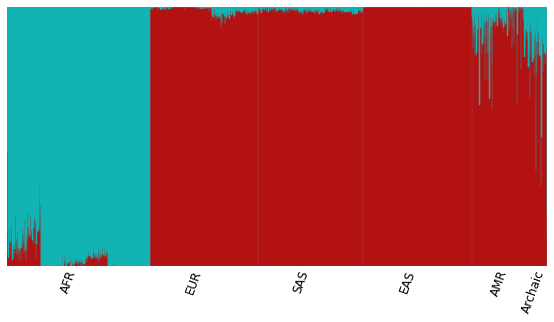

In [35]:
# Admixture plot where each color represents one cluster
plot_admixture(admix, individuals.super_population.cat.codes, individuals.super_population.cat.categories);

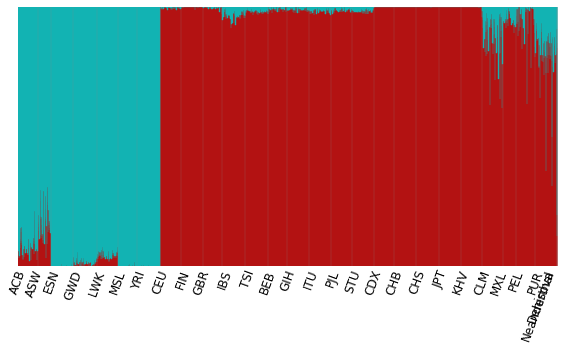

In [36]:
# Admixture plot with subcontinental ancestry where each color represents one cluster
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

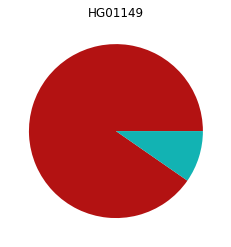

In [37]:
# Admixture output for the current individual
plot_admix_individual(admix, my_individual)

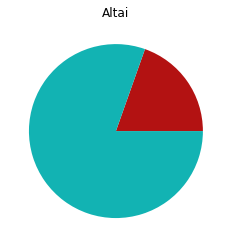

In [38]:
# Admixture output for Altai Neanderthal. 
plot_admix_individual(admix, 'Altai')

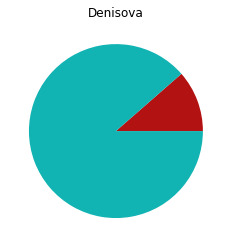

In [39]:
# Admixture output for Denisova. 
plot_admix_individual(admix, 'Denisova')

In [40]:
# Now let's run admixture with K=3 clusters
!../../bin/admixture --cv 1000G_archaic.bed 3

****                   ADMIXTURE Version 1.21                   *****
****                    Copyright 2008-2011                     *****
****          David Alexander, John  Novembre, Ken Lange        *****
****                   Please cite our paper!                   *****
****   Information at www.genetics.ucla.edu/software/admixture  *****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 2506x19998
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 2.962	Loglikelihood: -4.51512e+07	(delta): 3.55314e+07
2 (EM) 	Elapsed: 3.004	Loglikelihood: -4.38197e+07	(delta): 1.33149e+06
3 (EM) 	Elapsed: 3.082	Loglikelihood: -4.34422e+07	(delta): 377505
4 (EM) 	Elapsed: 2.948	Loglikelihood: 

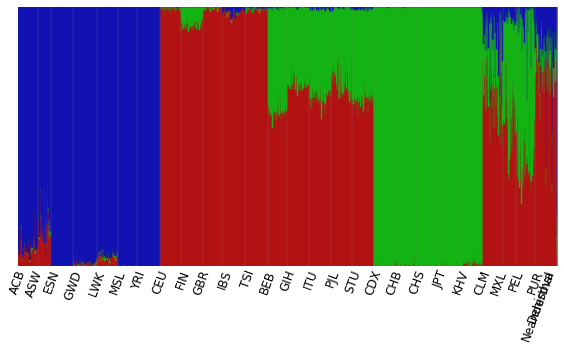

In [41]:
# Display output of ADMIXTURE (K=3)
admix = pd.read_csv('1000G_archaic.3.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

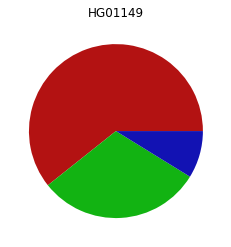

In [42]:
# Admixture output for the current individual (K=3)
plot_admix_individual(admix, my_individual)

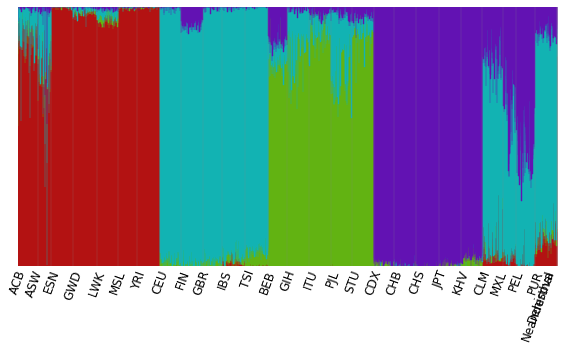

In [43]:
# For K=4,5,6 results have been precomputed, we can just load them. Display output of ADMIXTURE (K=4)
admix = pd.read_csv('1000G_archaic.4.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

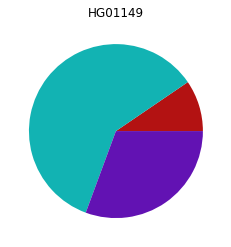

In [44]:
# Admixture output for the current individual (K=4)
plot_admix_individual(admix, my_individual)

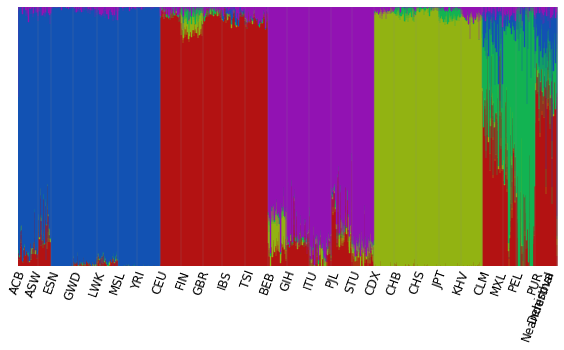

In [45]:
# Display output of ADMIXTURE (K=5)
admix = pd.read_csv('1000G_archaic.5.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

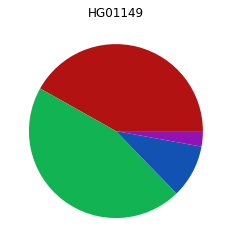

In [46]:
# Admixture output for the current individual (K=5)
plot_admix_individual(admix, my_individual)

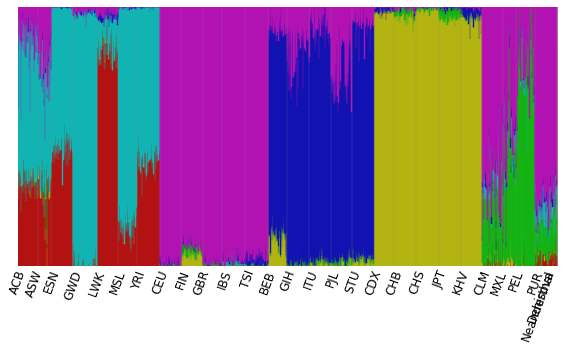

In [47]:
# Display output of ADMIXTURE (K=6)
admix = pd.read_csv('1000G_archaic.6.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

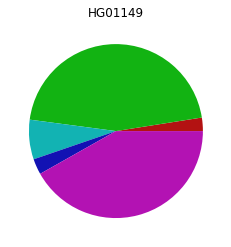

In [48]:
# Admixture output for the current individual (K=6)
plot_admix_individual(admix, my_individual)

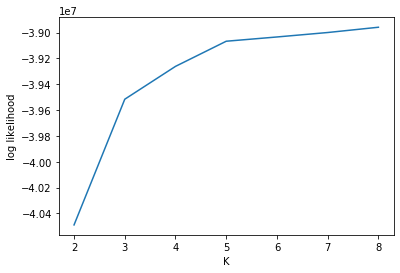

In [49]:
# Likelihood of data as a function of K, the number of clusters
K = np.arange(2, 9)
log_likelihood = [-40488756, -39516004, -39261878, -39067307, -39034320, -38999856, -38959044]
plt.plot(K, log_likelihood)
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('log likelihood');

# Analysis of archaic introgression

Skov, Laurits, et al. "Detecting archaic introgression using an unadmixed outgroup." PLoS genetics 14.9 (2018): e1007641.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007641

Software: https://github.com/LauritsSkov/Introgression-detection

Usage:

`!python2 Introgression-detection/Train.py infile outprefix model weights_file mutfile`

`!python2 Introgression-detection/Decode.py infile outprefix model weights_file mutfile window_size`

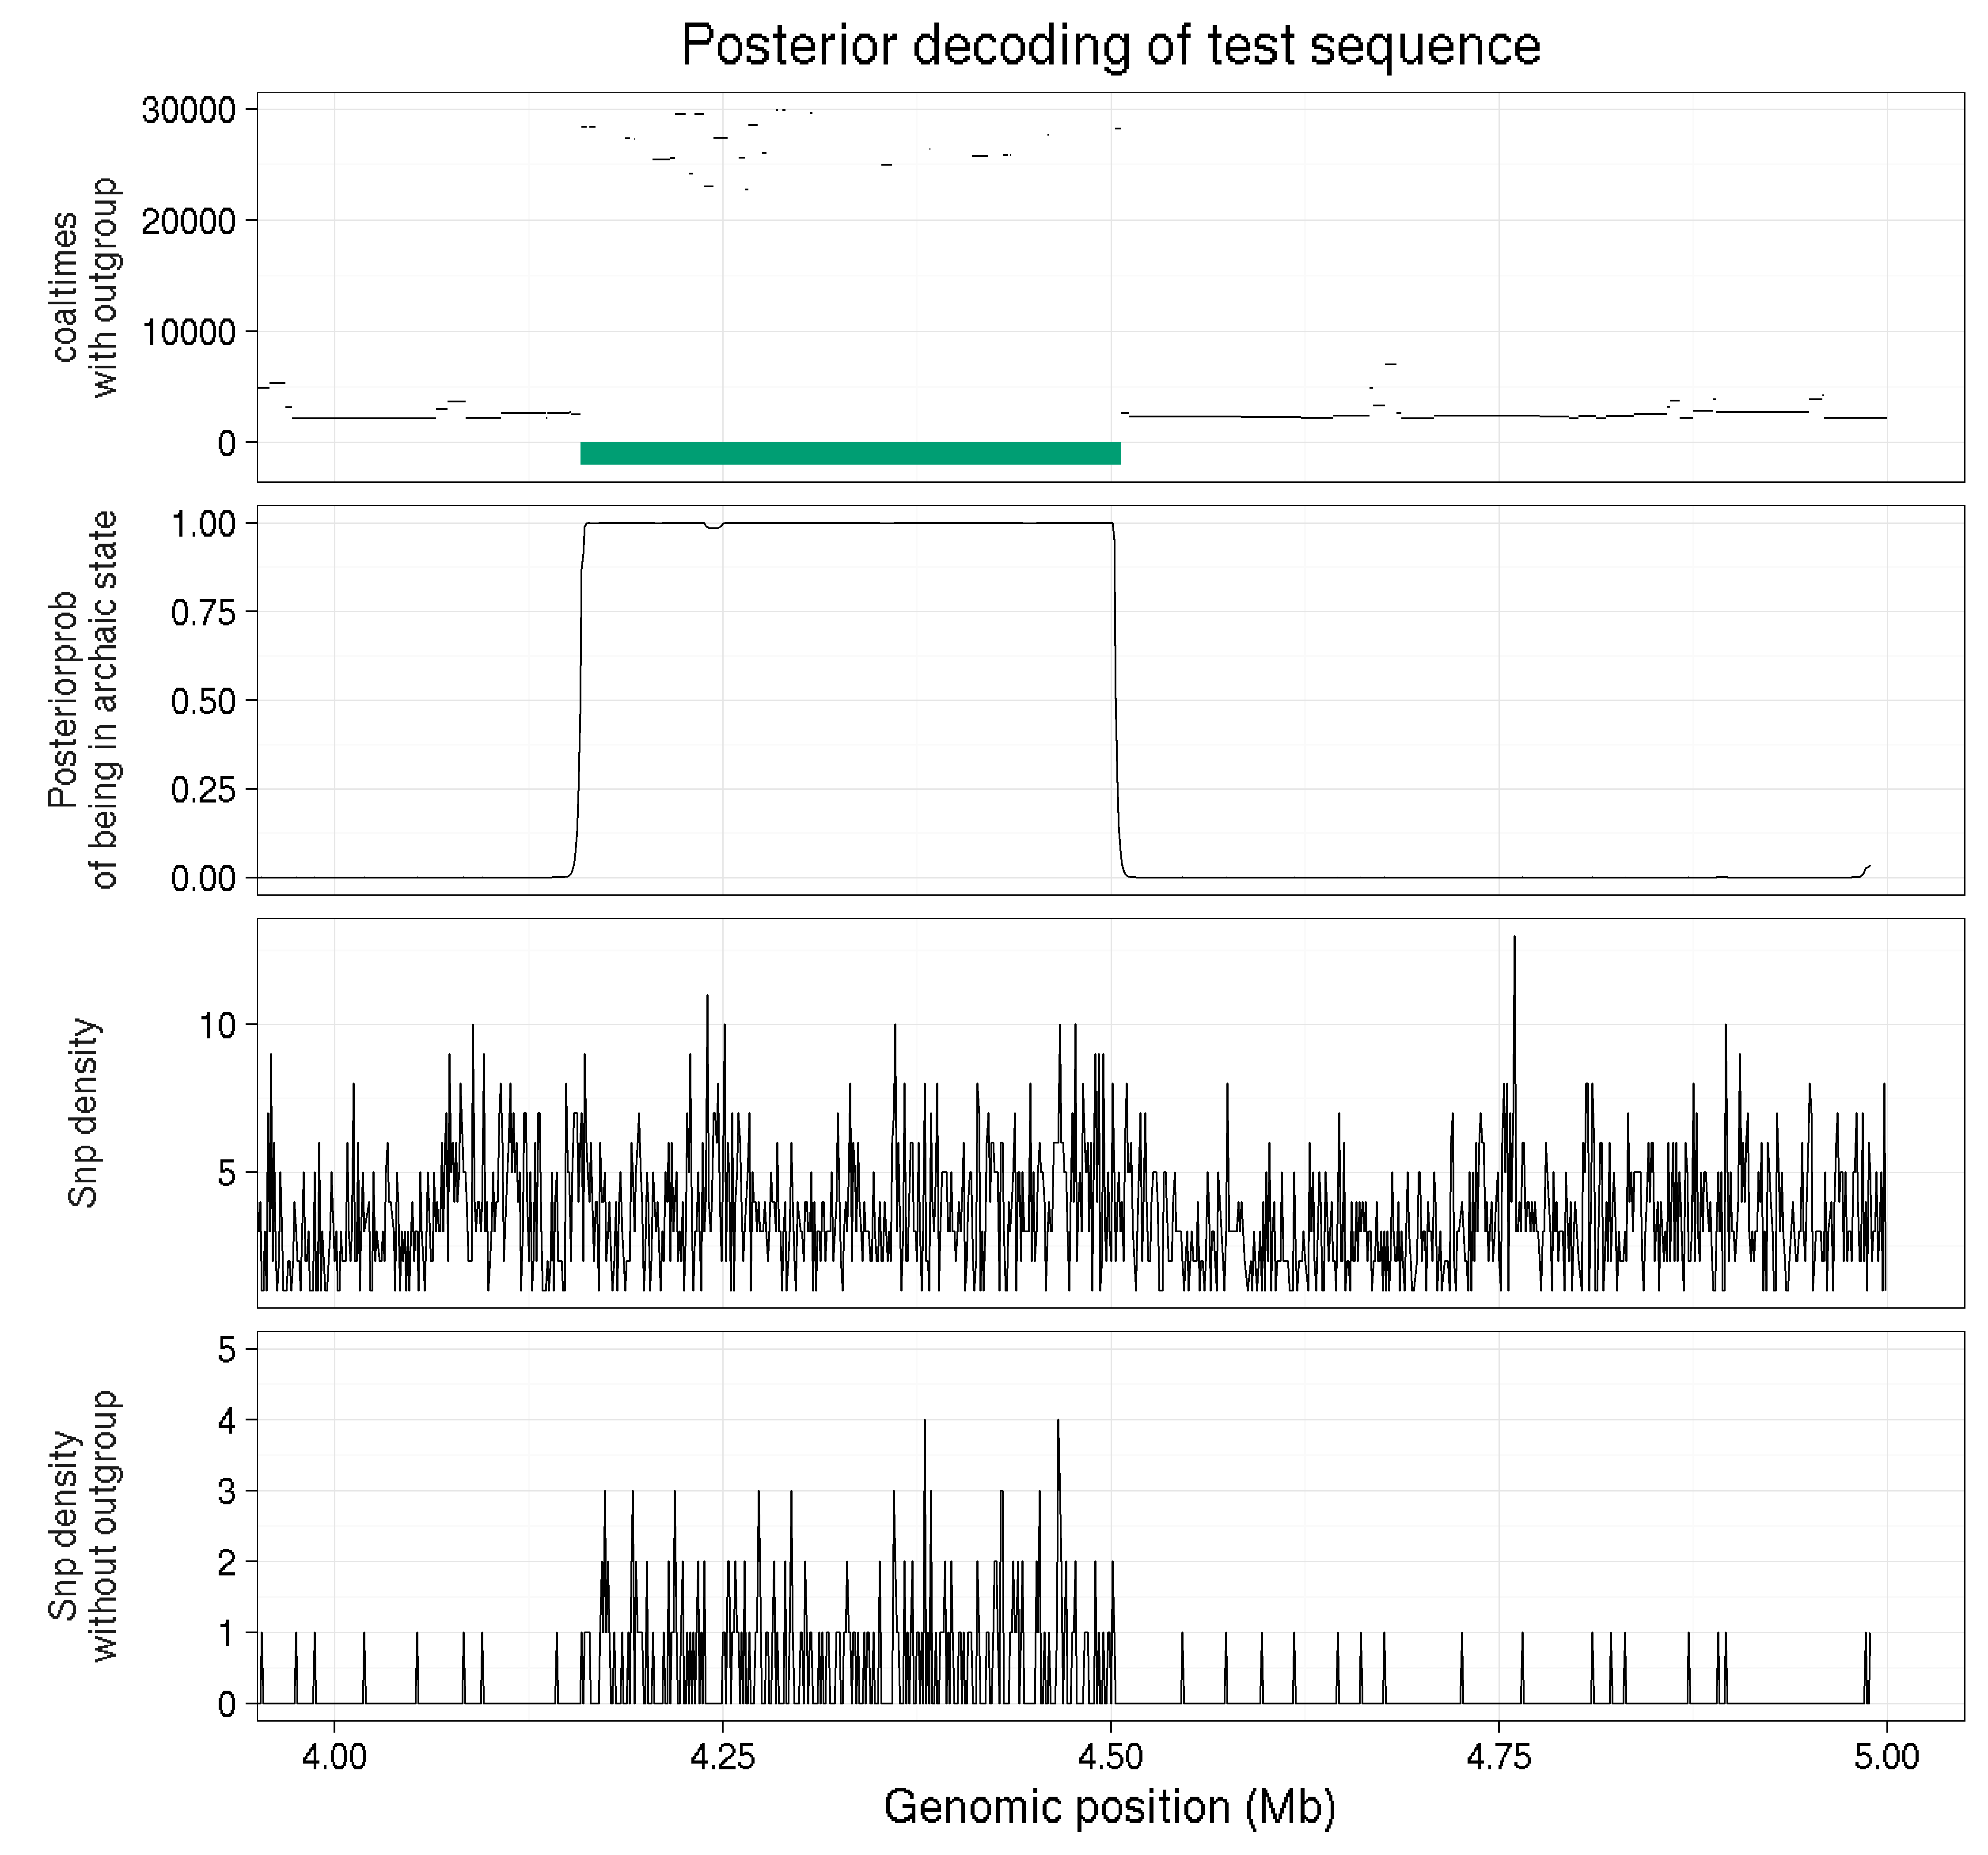

In [50]:
# Signal of archaic admixture
Image(filename='hmm-skov-3.png', height=500)

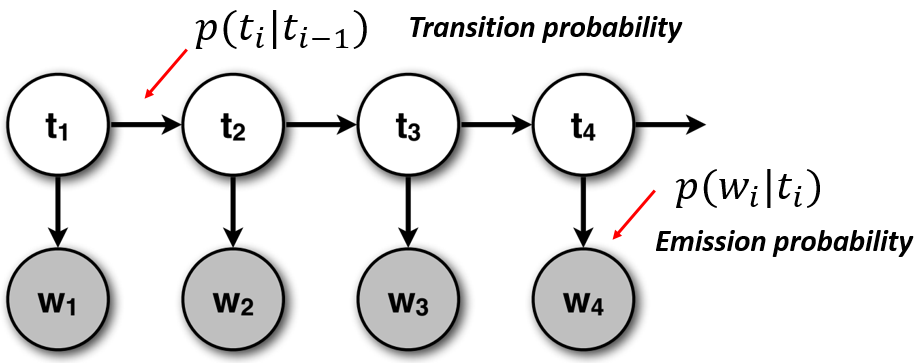

In [51]:
# What is an HMM
Image(filename='hmm.png', height=200) 

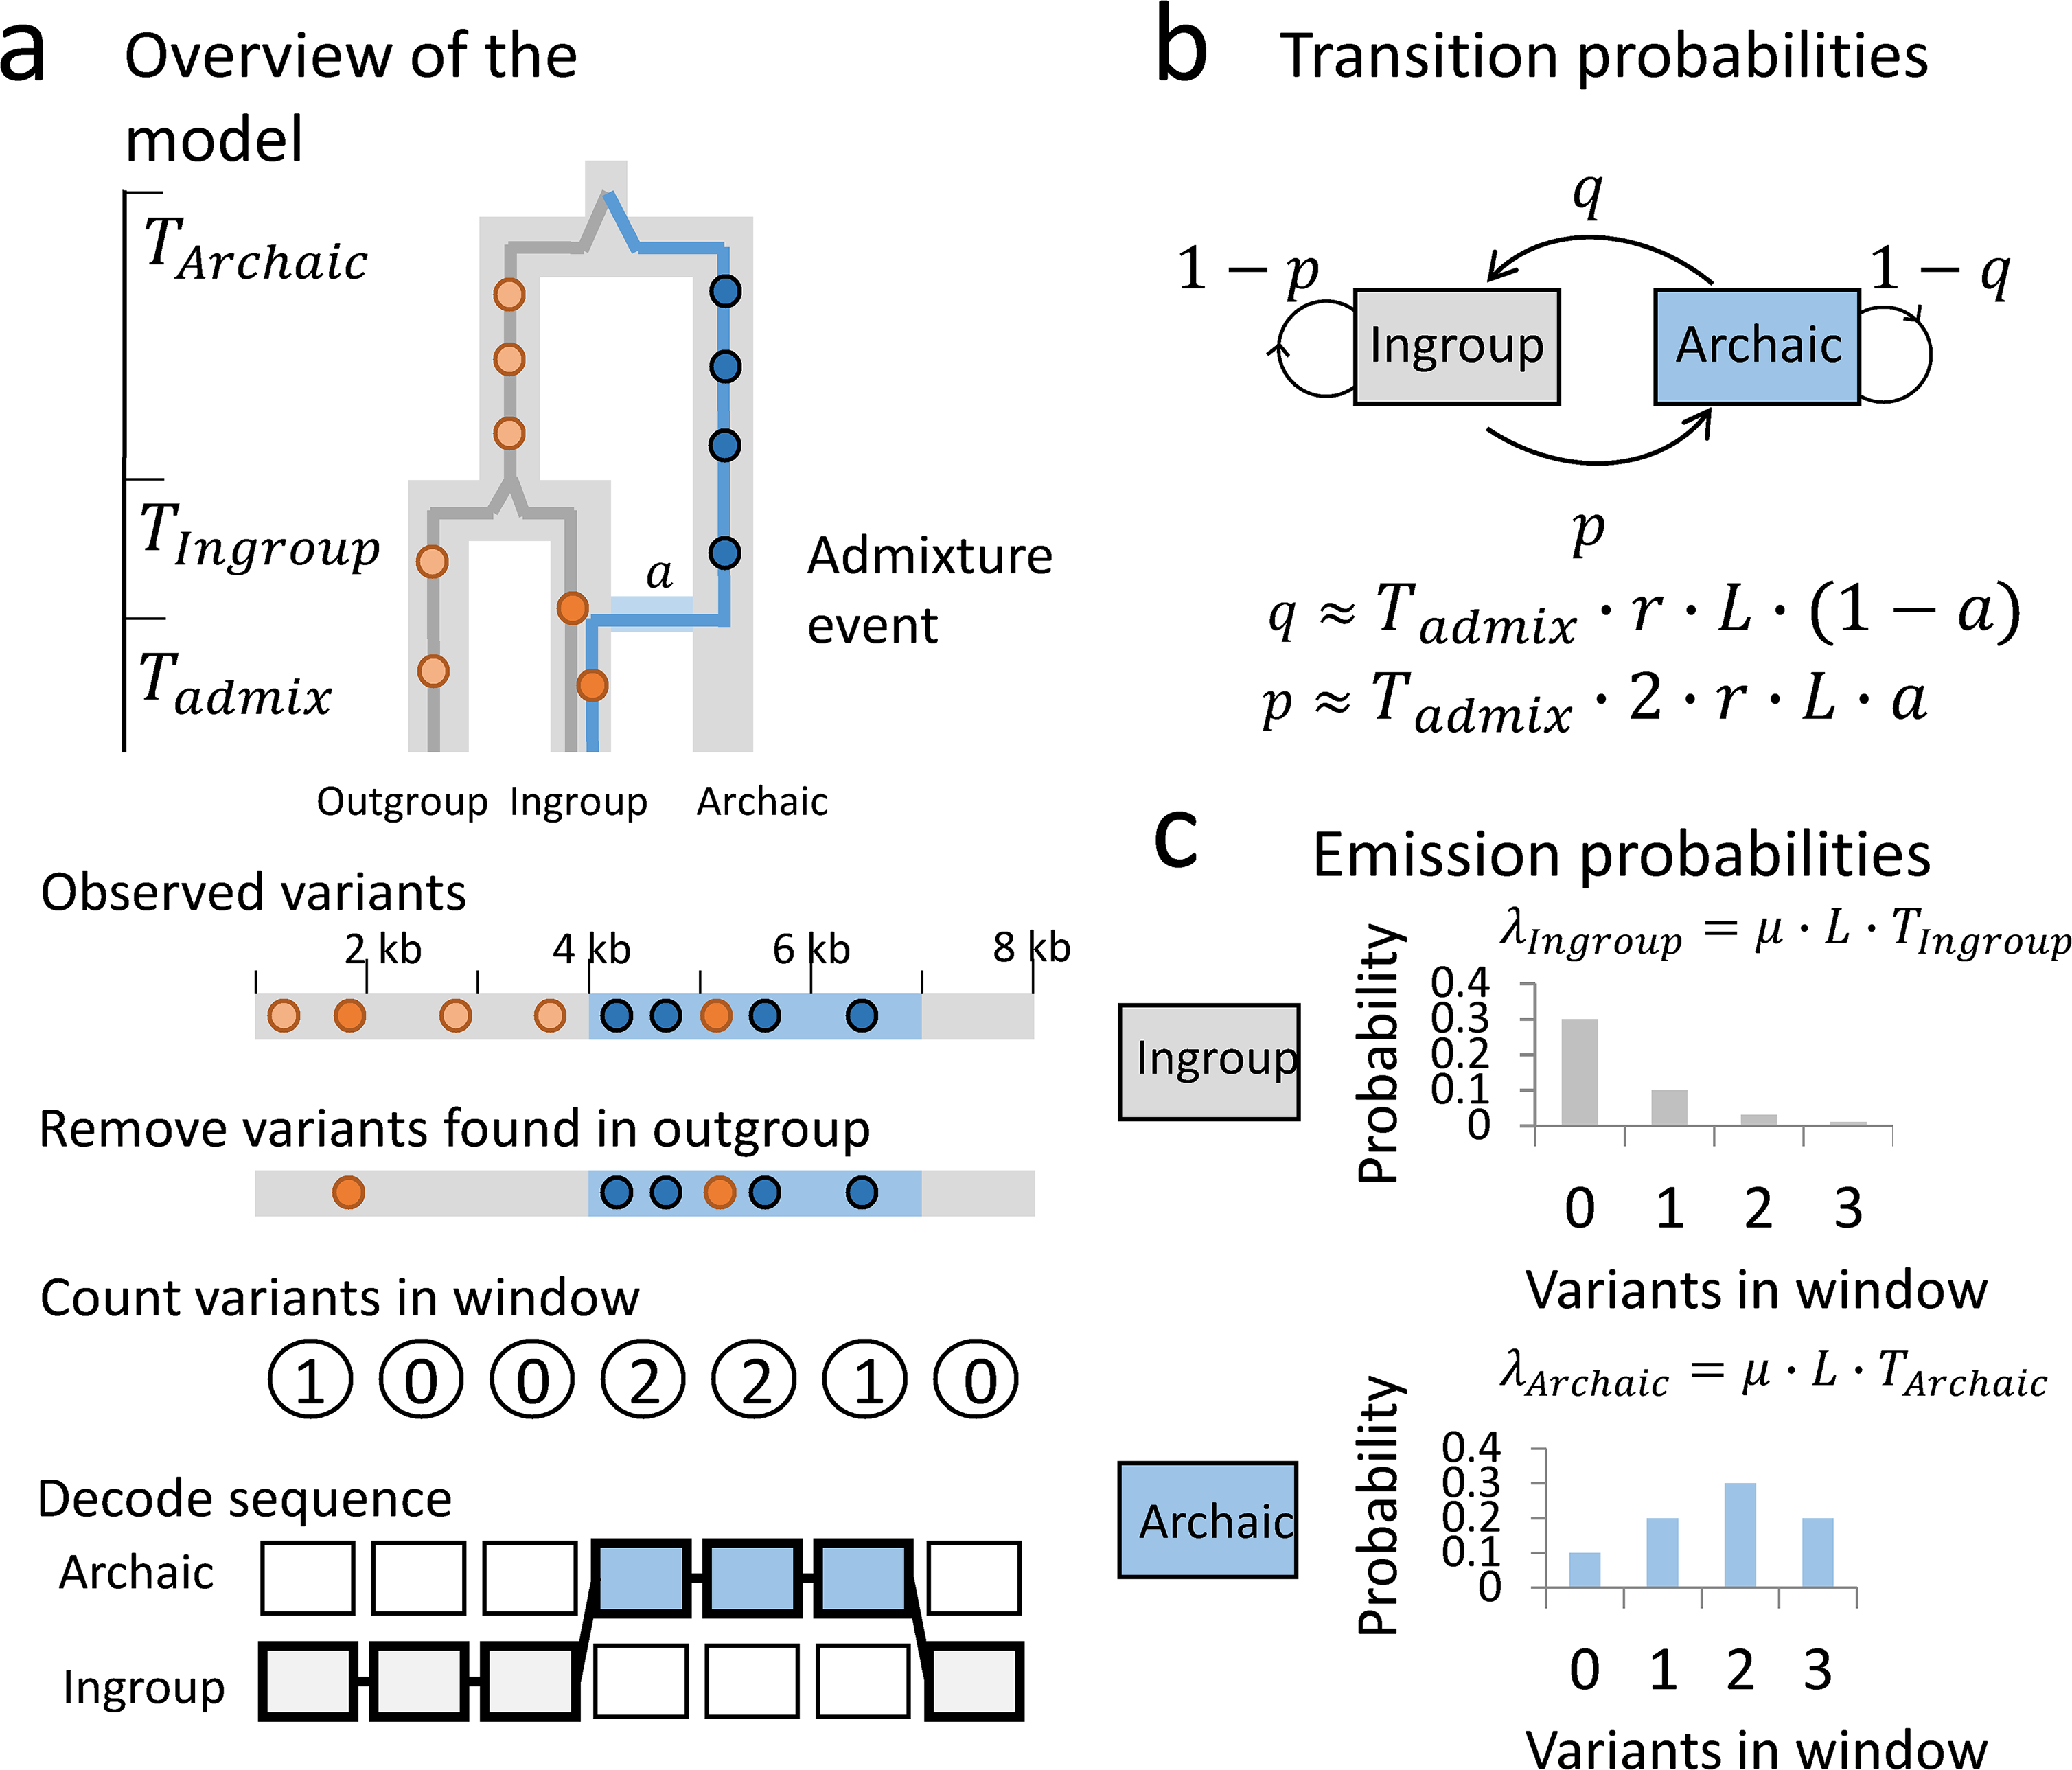

In [52]:
# Main idea for identifying segments of archaic ancestry
Image(filename='hmm-skov-2.png', height=500)

In [0]:
# SKIP
#!python2 Introgression-detection/MakeMaskfiles.py chr17.fa.masked 20140520.chr17.strict_mask.fasta.gz 1000 17 chr17
#!cp chr17.txt weights.txt
#!cp chr17.bed weights.bed
#!cat integrated_call_samples_v3.20130502.ALL.panel | grep -E "YRI|ESN|MSL" | cut -f 1 > outgroups.txt
#!tabix -h ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -R chr17.bed | vcftools --vcf - --counts --stdout --keep outgroups.txt --remove-indels --min-alleles 2 --max-alleles 2 > chr17.freq
#!python2 Introgression-detection/Estimate_mutationrate.py chr17.freq 1000000 1000 chr17.txt chr17.mut
#!cp chr17.mut mutationrates.txt
#!tabix -fh ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz -R chr17.bed | vcftools --vcf - --indv HG00096 --remove-indels --min-alleles 2 --max-alleles 2 --stdout --counts | python2 Introgression-detection/Filtervariants.py homo_sapiens_ancestor_17.fa chr17.freq 1000 chr17.txt HG00096.chr17.observations.txt

In [0]:
# Configure files for the current individual
os.system('cp {}.chr17.observations.txt observations.txt'.format(my_individual));

In [55]:
# Define initial parameters for the HMM
%%writefile StartingParameters.hmm
# State names (only used for decoding)
states = ['Human','Archaic']

# Initialization parameters (prob of staring in states)
starting_probabilities = [0.98, 0.02]

# transition matrix
transitions = [[0.9995,0.0005],[0.012,0.98]]

# emission matrix (poisson parameter)
emissions = [0.04, 0.1]

Writing StartingParameters.hmm


In [56]:
# Train the HMM model
!python2 Introgression-detection/Train.py observations.txt trained StartingParameters.hmm weights.txt mutationrates.txt

/content/CCB293/data/1000G_archaic/Introgression-detection/templates.py:278: RuntimeWarning: divide by zero encountered in log
  top = np.logaddexp.reduce(forwards[state,:] + backwards[state,:] + np.log(observations))
/content/CCB293/data/1000G_archaic/Introgression-detection/templates.py:279: RuntimeWarning: divide by zero encountered in log
  bottom = np.logaddexp.reduce(forwards[state,:] + backwards[state,:] + np.log(weights * mutrates) )
doing iteration 0 with old prob -11610.7920784 and new prob -10738.1554202
doing iteration 1 with old prob -10738.1554202 and new prob -10519.1650716
doing iteration 2 with old prob -10519.1650716 and new prob -10420.7471637
doing iteration 3 with old prob -10420.7471637 and new prob -10365.2380174
doing iteration 4 with old prob -10365.2380174 and new prob -10329.6595117
doing iteration 5 with old prob -10329.6595117 and new prob -10309.2946256
doing iteration 6 with old prob -10309.2946256 and new prob -10297.0710393
doing iteration 7 with old pr

In [57]:
# Display trained parameters
!cat trained.hmm

# State names (only used for decoding)
states = ['Human','Archaic']

# Initialization parameters (prob of staring in states)
starting_probabilities = [0.9914365597456, 0.008563440254358668]

# transition matrix
transitions = [[0.9998531139210742,0.0001468860789256895],[0.016999264798519157,0.9830007352014808]]

# emission matrix (poisson parameter)
emissions = [0.06773383135796911, 2.4097918107535183]


In [0]:
# Decode the most likely assignment of ancestry to windows
!python2 Introgression-detection/Decode.py observations.txt decoded trained.hmm weights.txt mutationrates.txt 1000

In [59]:
# Inference for every 1000Kb window
posterior_probs = pd.read_csv('decoded.All_posterior_probs.txt', '\t')
posterior_probs.head()

,chrom,start,observations,variants,Mostlikely,Human,Archaic
0,17,0,0,NaN,Human,0.999864,0.000136
1,17,1000,0,NaN,Human,0.999982,0.000018
2,17,2000,0,NaN,Human,0.999997,0.000003
3,17,3000,0,NaN,Human,0.999997,0.000003
4,17,4000,0,NaN,Human,0.999996,0.000004


In [60]:
posterior_probs[posterior_probs.observations>0].head()

,chrom,start,observations,variants,Mostlikely,Human,Archaic
42,17,42000,1,42756,Human,0.999829,0.000171
49,17,49000,1,49569,Human,0.999991,0.000009
73,17,73000,1,73654,Human,0.999725,0.000275
76,17,76000,1,76510,Human,0.999989,0.000011
82,17,82000,1,82381,Human,0.967746,0.032254


In [61]:
# The most likeliy assignment of ancestry to the whole chromosome, split into contiguous segments of same ancestry
decoded_summary = pd.read_csv('decoded.Summary.txt', '\t')
decoded_summary.head()

,name,chrom,start,end,length,state,snps,mean_prob
0,decoded,17,0,12557000,12557000,Human,438,0.999458
1,decoded,17,12557000,12566000,9000,Archaic,6,0.853354
2,decoded,17,12566000,12618000,52000,Human,8,0.986419
3,decoded,17,12618000,12649000,31000,Archaic,22,0.943389
4,decoded,17,12649000,43724000,31075000,Human,752,0.998450


In [0]:
# Obtain the windows ancestry assignment
window_assignment = (posterior_probs.Mostlikely=='Archaic')

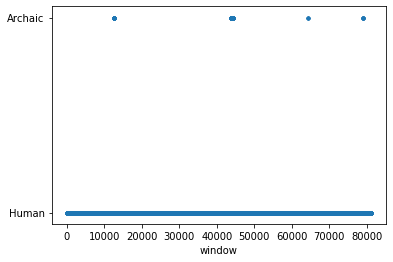

In [63]:
# Plot the assignment of the whole chromosome
plot_window_assignment(window_assignment)

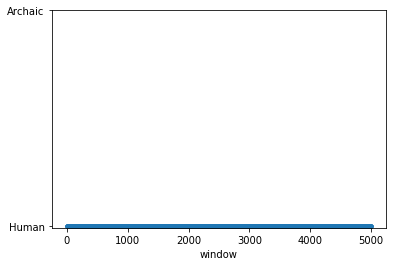

In [64]:
# Plot assignment of the first 5000 windows
plot_window_assignment(window_assignment[:5000])

In [0]:
# Obtain number of observations per window of Human or Archaic ancestry
obs_human = posterior_probs.observations[posterior_probs.Mostlikely=='Human']
obs_archaic = posterior_probs.observations[posterior_probs.Mostlikely=='Archaic']
max_human = obs_human.max()
max_archaic = obs_archaic.max()

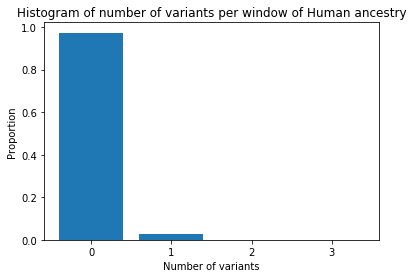

In [66]:
# Plot the number of variants per window of human ancestry
plt.bar(np.arange(max_human+1), [(obs_human==i).mean() for i in range(max_human+1)]);
plt.xticks(np.arange(max_human+1));
plt.xlabel('Number of variants')
plt.ylabel('Proportion')
plt.title('Histogram of number of variants per window of Human ancestry');

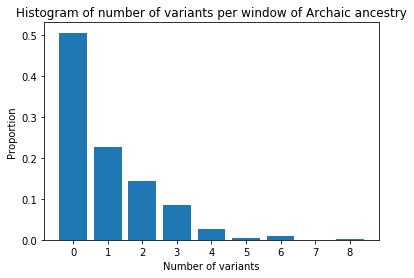

In [67]:
# Plot the number of variants per window of archaic ancestry
plt.bar(np.arange(max_archaic+1), [(obs_archaic==i).mean() for i in range(max_archaic+1)]);
plt.xticks(np.arange(max_archaic+1));
plt.xlabel('Number of variants')
plt.ylabel('Proportion')
plt.title('Histogram of number of variants per window of Archaic ancestry');